# Detecting sexism in songs 

## Importing and Opening files

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sn 
import pathlib
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB


# Loading

In [3]:
df_training = pd.read_csv('/Users/kiliandiederix/Desktop/Sexist/EXIST2021_training.tsv', sep='\t')
df_test= pd.read_csv('/Users/kiliandiederix/Desktop/Sexist/EXIST2021_test.tsv', sep='\t')
df_test_label= pd.read_csv('/Users/kiliandiederix/Desktop/Sexist/EXIST2021_test_labeled.tsv', sep='\t')

In [4]:
#Seperating out spanish tweets
# dropping the spanish tweets from both training and test datasets, we will train only on english and predict english tweets
df_training= df_training[df_training['language']=='en']
df_test_label= df_test_label[df_test_label['language']=='en']


# Inspection

In [5]:
df_training.head(-5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist
...,...,...,...,...,...,...,...
3426,EXIST2021,3427,twitter,en,@moranicly @bullrike @Manaxium This is because...,sexist,ideological-inequality
3427,EXIST2021,3428,twitter,en,@wanttaem i am also a whore for dilfs,sexist,sexual-violence
3428,EXIST2021,3429,twitter,en,Yes finally somebody said it. Why it bothers ...,sexist,objectification
3429,EXIST2021,3430,twitter,en,Sodomizing Saturday is wonderful. I need someo...,sexist,sexual-violence


In [6]:
df_test_label.head(-5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,6978,gab,en,Pennsylvania State Rep horrifies with opening ...,non-sexist,non-sexist
1,EXIST2021,6979,twitter,en,"@iilovegrapes He sounds like as ass, and very ...",non-sexist,non-sexist
2,EXIST2021,6980,twitter,en,"@averyangryskel1 @4ARealistParty LOL! ""This be...",sexist,ideological-inequality
3,EXIST2021,6981,twitter,en,@WanderOrange @stalliontwink Rights?I mean yea...,sexist,ideological-inequality
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i’m seeing is o...,non-sexist,non-sexist
...,...,...,...,...,...,...,...
2198,EXIST2021,9176,twitter,en,List Of Very Useless Pieces of Information 1. ...,non-sexist,non-sexist
2199,EXIST2021,9177,twitter,en,@GavinWax Redheads don't usually wear much mak...,sexist,objectification
2200,EXIST2021,9178,twitter,en,bitches with repressed anger be like HHOOLLYYY...,sexist,misogyny-non-sexual-violence
2201,EXIST2021,9179,twitter,en,"You may not see it but know that, if a woman i...",non-sexist,non-sexist


In [7]:
print(df_training['task1'].value_counts())
print(df_training['language'].value_counts())
#The below distributions show there is almost an equal distribution of our labels

non-sexist    1800
sexist        1636
Name: task1, dtype: int64
en    3436
Name: language, dtype: int64


Text(0.5, 1.0, 'Dataset labels distribuition')

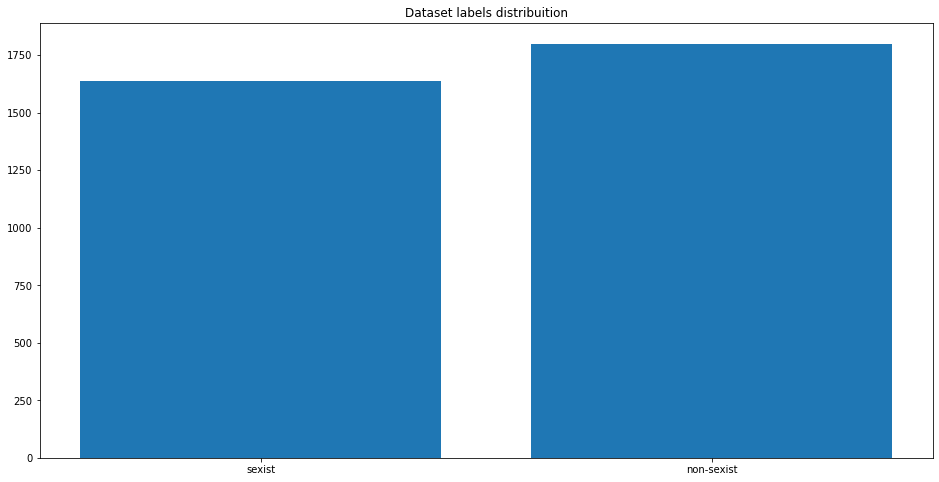

In [8]:
target_cnt = Counter(df_training['task1'])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [9]:
df_training.isnull().sum()

test_case    0
id           0
source       0
language     0
text         0
task1        0
task2        0
dtype: int64

In [10]:
df_test_label.isnull().sum()

test_case    0
id           0
source       0
language     0
text         0
task1        0
task2        0
dtype: int64

# Preprocessing steps

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [15]:
df_training['text_fin'] = df_training['text'].apply(lambda x: preprocess(x))

In [16]:
df_test_label['text_fin'] = df_test_label['text'].apply(lambda x: preprocess(x))

In [17]:
df_training['class']= np.where(df_training['task1']=='sexist',0,1)

In [18]:
df_test_label['class']= np.where(df_test_label['task1']=='sexist',0,1)

In [19]:
df_training['text_fin']=df_training['text_fin'].apply(simple_stemmer)
df_test_label['text_fin']=df_test_label['text_fin'].apply(simple_stemmer)

In [20]:
df_training

,test_case,id,source,language,text,task1,task2,text_fin,class
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality,call anti feminazi shut fuck vile commentari e...,0
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist,back women brave beauti clare crawley tayshia ...,1
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification,xalynn b wow skirt short length 5 inch,0
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist,incred beauti laugh much read drift wheelchair...,1
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,find extrem hard believ kelli 66 yr old mum wo...,1
...,...,...,...,...,...,...,...,...,...
3431,EXIST2021,3432,twitter,en,Do you think the biggest crisis in masculinity...,sexist,objectification,think biggest crisi masculin damag societi men...,0
3432,EXIST2021,3433,twitter,en,my bank account looks like a street whore,sexist,misogyny-non-sexual-violence,bank account look like street whore,0
3433,EXIST2021,3434,twitter,en,-Lev put his hand on your upper thighs. And ru...,sexist,objectification,lev put hand upper thigh rub circl around thin...,0
3434,EXIST2021,3435,twitter,en,@adamm_mo I believe u can let ur wife work any...,sexist,stereotyping-dominance,believ u let ur wife work anywher busi offic d...,0


In [21]:
X_train= df_training['text_fin']
Y_train= df_training['class']

X_test= df_test_label['text_fin']
Y_test= df_test_label['class']

# Logistic Regression model

In [22]:
cv=CountVectorizer(ngram_range=(1,2)) 
x_train_trans=cv.fit_transform(X_train)

In [23]:
lr_model=LogisticRegression(random_state=21) # Defining the model
lr_model.fit(x_train_trans,Y_train) # training the model

LogisticRegression(random_state=21)

In [24]:
pred_Y=lr_model.predict(cv.transform(X_test)) # predicting
#checking the accuracy
score_1=accuracy_score(Y_test,pred_Y)
print("Model Accuracy:",score_1)

Model Accuracy: 0.7237318840579711


In [25]:
# checking the other metrics
print(classification_report(Y_test, pred_Y))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1158
           1       0.69      0.75      0.72      1050

    accuracy                           0.72      2208
   macro avg       0.72      0.73      0.72      2208
weighted avg       0.73      0.72      0.72      2208



In [26]:
len(pred_Y)

2208

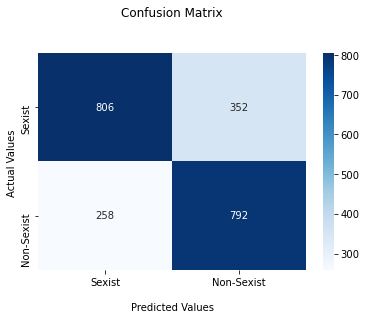

In [27]:
cf_matrix = confusion_matrix(Y_test, pred_Y)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Sexist','Non-Sexist'])
ax.yaxis.set_ticklabels(['Sexist','Non-Sexist'])

## Display the visualization of the Confusion Matrix.
plt.show()

### with TF-IDF

In [28]:
# Convert raw frequency counts into TF-IDF values
tfidf_transformer = TfidfTransformer()
Xtrain_tfidf = tfidf_transformer.fit_transform(x_train_trans)

In [29]:
lr_model2=LogisticRegression(random_state=21) # Defining the model
lr_model2.fit(Xtrain_tfidf,Y_train) # training the model

LogisticRegression(random_state=21)

In [30]:
pred_Y2=lr_model2.predict(tfidf_transformer.transform(cv.transform(X_test))) # predicting
#checking the accuracy
score_1=accuracy_score(Y_test,pred_Y2)
print("Model Accuracy:",score_1)

Model Accuracy: 0.7196557971014492


In [31]:
# checking the other metrics
print(classification_report(Y_test, pred_Y2))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1158
           1       0.70      0.71      0.71      1050

    accuracy                           0.72      2208
   macro avg       0.72      0.72      0.72      2208
weighted avg       0.72      0.72      0.72      2208



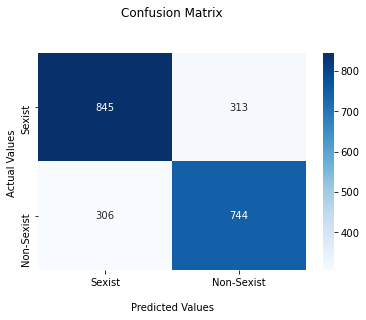

In [32]:
cf_matrix = confusion_matrix(Y_test, pred_Y2)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Sexist','Non-Sexist'])
ax.yaxis.set_ticklabels(['Sexist','Non-Sexist'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Min df=4 (TF-IDF)

In [33]:
cv4 = CountVectorizer(min_df=4, ngram_range=(1,2))

In [34]:
x_train_trans4=cv4.fit_transform(X_train)

In [35]:
Xtrain_tfidf4 = tfidf_transformer.fit_transform(x_train_trans4)

In [36]:
lr_model4=LogisticRegression(random_state=21) # Defining the model
lr_model4.fit(Xtrain_tfidf4,Y_train) # training the model

LogisticRegression(random_state=21)

In [37]:
pred_Y4=lr_model4.predict(tfidf_transformer.transform(cv4.transform(X_test))) # predicting
#checking the accuracy
score_1=accuracy_score(Y_test,pred_Y4)
print("Model Accuracy:",score_1)

Model Accuracy: 0.7160326086956522


In [38]:
# checking the other metrics
print(classification_report(Y_test, pred_Y4))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1158
           1       0.68      0.76      0.72      1050

    accuracy                           0.72      2208
   macro avg       0.72      0.72      0.72      2208
weighted avg       0.72      0.72      0.72      2208



## Min df=6 (TF-IDF)

In [39]:
cv6 = CountVectorizer(min_df=6, ngram_range=(1,2))

In [40]:
x_train_trans6=cv6.fit_transform(X_train)

In [41]:
lr_model6=LogisticRegression(random_state=21) # Defining the model
lr_model6.fit(x_train_trans6,Y_train) # training the model

LogisticRegression(random_state=21)

In [42]:
pred_Y6=lr_model6.predict(cv6.transform(X_test)) # predicting
#checking the accuracy
score_1=accuracy_score(Y_test,pred_Y6)
print("Model Accuracy:",score_1)

Model Accuracy: 0.7092391304347826


In [43]:
# checking the other metrics
print(classification_report(Y_test, pred_Y6))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1158
           1       0.68      0.74      0.71      1050

    accuracy                           0.71      2208
   macro avg       0.71      0.71      0.71      2208
weighted avg       0.71      0.71      0.71      2208



## Min df=8 (TF-IDF)

In [44]:
cv8 = CountVectorizer(min_df=8, ngram_range=(1,2))

In [45]:
x_train_trans8=cv8.fit_transform(X_train)

In [46]:
Xtrain_tfidf8 = tfidf_transformer.fit_transform(x_train_trans8)

In [47]:
lr_model8=LogisticRegression(random_state=21) # Defining the model
lr_model8.fit(Xtrain_tfidf8,Y_train) # training the model

LogisticRegression(random_state=21)

In [48]:
pred_Y8=lr_model8.predict(tfidf_transformer.transform(cv8.transform(X_test))) # predicting
#checking the accuracy
score_1=accuracy_score(Y_test,pred_Y8)
print("Model Accuracy:",score_1)

Model Accuracy: 0.7219202898550725


In [49]:
# checking the other metrics
print(classification_report(Y_test, pred_Y8))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1158
           1       0.69      0.77      0.72      1050

    accuracy                           0.72      2208
   macro avg       0.72      0.72      0.72      2208
weighted avg       0.73      0.72      0.72      2208



# Classifier

In [50]:
clf = MultinomialNB().fit(x_train_trans,Y_train)

In [51]:
y_pred2 = clf.predict(cv.transform(X_test))
score_1=accuracy_score(Y_test,y_pred2)
print("Model Accuracy:",score_1)

Model Accuracy: 0.6834239130434783


In [52]:
# checking the other metrics
print(classification_report(Y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1158
           1       0.67      0.65      0.66      1050

    accuracy                           0.68      2208
   macro avg       0.68      0.68      0.68      2208
weighted avg       0.68      0.68      0.68      2208



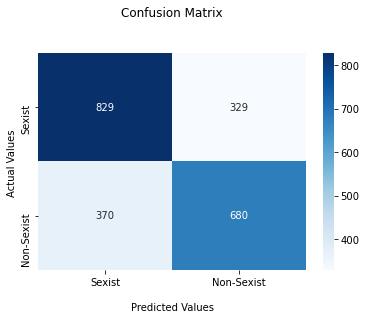

In [53]:
cf_matrix = confusion_matrix(Y_test, y_pred2)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Sexist','Non-Sexist'])
ax.yaxis.set_ticklabels(['Sexist','Non-Sexist'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Classifier with tf-idf

In [54]:
# Convert raw frequency counts into TF-IDF values
Xtrain_tfidfclass = tfidf_transformer.fit_transform(x_train_trans)

In [55]:
clf2 = MultinomialNB().fit(Xtrain_tfidfclass,Y_train)

In [56]:
y_pred3 = clf2.predict(tfidf_transformer.transform(cv.transform(X_test)))
score_1=accuracy_score(Y_test,y_pred3)
print("Model Accuracy:",score_1)

Model Accuracy: 0.6784420289855072


In [57]:
# checking the other metrics
print(classification_report(Y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      1158
           1       0.64      0.74      0.69      1050

    accuracy                           0.68      2208
   macro avg       0.68      0.68      0.68      2208
weighted avg       0.68      0.68      0.68      2208



# Lyrics dataset

# new song dataset

In [65]:
data = {'song': ['Some Girls', 'kim', 'Young girl', 'Blurred lines','girls like you','Gods plan',"bitches ain't shit",
                 'The A team','Little bad girl',"Baby it's cold outside","Still loving you",'Chiquitita',"If i ain't got you",
                 "Can't hold us","animals","Hey Good Lookin","Hard out here","Hotline Bling","God made girls","I like it"],
        'genre': ['Rock', '(Horror) Hip hop/Rap', 'Pop', 
                 'RnB/Pop','Pop/Pop Rock','Pop rap/Trap',"Rap",'Folk','House',"Seasonal","Hard rock","Pop","RnB/Soul","Hip Hop/Rock",
                  "Pop","country","Pop","Pop/RnB", "Country/Pop","Trap/Hip Hop"], 
        'lyrics': ["""Some girls give me money, some girls buy me clothes
Some girls give me jewelry, that I never thought I'd own
Some girls give me diamonds, some girls, heart attacks
Some girls I give all my bread to, I don't ever want it back
Some girls give me jewelry, others buy me clothes
Some girls give me children, I never asked them for
So give me all your money, give me all your gold
I'll buy you a house in Baker Street, and give you half of what I own
Some girls take my money, some girls take my clothes
Some girls get the shirt off my back, and leave me with a lethal dose
French girls they want Cartier, Italian girls want cars
American girls want everything in the world you can possibly imagine
English girls they're so prissy, I can't stand them on the telephone
Sometimes I take the receiver off the hook, I don't want them to ever call at all
White girls they're pretty funny, sometimes they drive me mad
Black girls just wanna get fucked all night, I just don't have that much jam
Chinese girls are so gentle, they're really such a tease
You never know quite what they're cookin', inside those silky sleeves
Give me all you money, give me all your gold
I'll buy you a house in Baker Street, and give you half of what I own
Some girls they're so pure, some girls so corrupt
Some girls give me children, I only made love to her once
Give me half your money, give me half your car
Give me half of everything, I'll make you world's biggest star
So gimme all your money, give me all your gold
Let's go back to Zuma beach, I'll give you half of everything I own""", """Aww, look at daddy's baby girl
That's daddy's baby, little sleepy head
Yesterday I changed your diaper, wiped you and powdered you
How did you get so big? Can't believe it, now you're two
Baby you're so precious, daddy's so proud of you
Sit down bitch! You move again I'll beat the shit out of you! (Okay)
Don't make me wake this baby! She don't need to see what I'm 'bout to do!
Quit crying, bitch! Why do you always make me shout at you?!
How could you just leave me and love him out the blue?!
Oh, what's the matter Kim, am I too loud for you?!
Too bad, bitch! You're gonna finally hear me out this time!
At first, I'm like: "Aight, you wanna throw me out; that's fine!"
But not for him to take my place! Are you out your mind?!
This couch, this TV, this whole house is mine!
How could you let him sleep in our bed?! Look it, Kim!
Look at your husband now! (No!) I said, look at him!
He ain't so hot now, is he, little punk?!
(Why are you doing this?!) Shut the fuck up!
(You're drunk! You're never gonna get away with this!)
You think I give a fuck?! Come on! We're going for a ride, bitch! (No!)
Sit up front! (We can't just leave Hailie alone! What if she wakes up?)
We'll be right back; well, I will: you'll be in the trunk!
So long, bitch you did me so wrong
I don't wanna go on, living in this world without you
You really fucked me Kim! You really did a number on me!
Never knew me cheatin' on you would come back to haunt me
But we was kids then, Kim! I was only eighteen
That was years ago! I thought we wiped the slate clean
That's fucked up! (I love you!) Oh God, my brain is racing
(I love you!) What are you doing? Change the station!
I hate this song! Does this look like a big joke? (No!)
There's a year-old little laying dead with a slit throat
In your living room! Ha-ha! What, you think I'm kidding you?!
You loved him didn't you? (No!)
Bullshit, you bitch! Don't fucking lie to me!
What the fuck's this guy's problem on the side of me?
Fuck you asshole! Yeah, bite me!
Kim, Kim! Why don't you like me? You think I'm ugly, don't you?
(It's not that!) No, you think I'm ugly (Baby)
Get the fuck away from me! Don't touch me!
I hate you! I hate you! I swear to God, I hate you!
Oh my God, I love you! How the fuck could you do this to me?!
(I'm sorry!) How the fuck could you do this to me?!
So long, bitch you did me so wrong
I don't wanna go on, living in this world without you
Come on, get out! (I can't! I'm scared!)
I said get out, bitch! (Let go of my hair!)
(Please don't do this, baby! Please! I love you!)
(Look, we can just take Hailie and leave!)
Fuck you! You did this to us! You did it! it's your fault!
Oh my God, I'm cracking up, get a grip Marshall!
Hey, remember the time we went to Brian's party
And you were, like, so drunk that you threw up all over Archie?
That was funny, wasn't it? (Yes) That was funny, wasn't it?! (Yes!)
See, it all makes sense, doesn't it?
You and your husband have a fight
One of you tries to grab a knife, and during the struggle
He accidentally gets his Adam's apple sliced! (No!)
And while this is going on, his son just woke up and he walks in
She panics and he gets his throat cut! (Oh my God!)
So now they both dead, and you slash your own throat
So now it's double homicide and suicide with no note!
I should've known better when you started to act weird
We coulda... hey, where you going? Get back here!
You can't run from me Kim! It's just us, nobody else!
You're only making this harder on yourself!
Ha-ha, got ya! Go ahead, yell!
Here, I'll scream with you! "Ah, somebody help!"
Don't you get it bitch? No one can hear you!
Now shut the fuck up and get what's coming to you!
You were supposed to love me!!
Now bleed bitch, bleed!! Bleed bitch, bleed!! Bleed!!
So long, bitch you did me so wrong
I don't wanna go on, living in this world without you
So long, bitch you did me so wrong
I don't wanna go on, living in this world without you""", """Young girl
Get out of my mind
My love for you is way out of line
Better run, girl
You're much too young, girl

With all the charms of a woman
You've kept the secret of your youth
You led me to believe you're old enough
To give me Love
And now it hurts to know the truth

Whoa, oh, oh, young girl
Get out of my mind
My love for you is way out of line
Better run, girl
You're much too young, girl

Beneath your perfume and make-up
You're just a baby in disguise
And though you know that it's wrong to be
Alone with me
That come on look is in your eyes

Whoa, oh, oh, young girl
Get out of my mind
My love for you is way out of line
Better run, girl
You're much too young, girl

So hurry home to your mama
I'm sure she wonders where you are
Get out of here before I have the time
To change my mind
'Cause I'm afraid we'll go too far

Whoa, oh, oh, young girl
Get out of my mind
My love for you is way out of line
Better run, girl
You're much too young, girl

Young girl
Get out of my mind
My love for you is way out of line
Better run, girl
You're much too young, girl

Young girl
Get out of my mind
My love for you""", """Everybody get up
Everybody get up (hey, hey, hey)
Hey, hey, hey (uh)
Hey, hey, hey (ha-ha) (woo)
Turn me up
If you can't hear what I'm trying to say (hey girl, come here)
If you can't read from the same page (hey)
Maybe I'm going deaf (hey, hey, hey)
Maybe I'm going blind (hey, hey, hey)
Maybe I'm out of my mind, mind (hey, hey, hey)
Okay, now he was close
Tried to domesticate you
But you're an animal
Baby, it's in your nature (meow)
Just let me liberate you (hey, hey, hey)
You don't need no takers (hey, hey, hey)
That man is not your maker (hey, hey, hey)
And that's why I'm gon' take a good girl (everybody get up)
I know you want it (hey)
I know you want it
I know you want it
You're a good girl (hey, hey)
Can't let it get past me (oh yeah)
You're far from plastic (alright)
Talkin' 'bout getting blasted
I hate these blurred lines
I know you want it (hey)
I know you want it (oh-oh-oh-oh, yeah-yeah)
I know you want it
But you're a good girl (ah, hey)
The way you grab me
Must wanna get nasty (ah, hey, hey)
Go ahead, get at me (everybody get up) (come on!)
What do they make dreams for
When you got them jeans on? (Why?)
What do we need steam for?
You the hottest bitch in this place
I feel so lucky (hey, hey, hey)
You wanna hug me (hey, hey, hey)
What rhymes with hug me? (Hey, hey, hey)
Hey (everybody get up)
Okay, now he was close
Tried to domesticate you
But you're an animal
Baby, it's in your nature (uh-huh)
Just let me liberate you (hey, hey, hey) (uh-huh)
You don't need no takers (hey, hey, hey) (uh-huh)
That man is not your maker (hey, hey, hey) (uh-huh)
And that's why I'm gon' take a good girl (everybody get up)
I know you want it
I know you want it (hey)
I know you want it
You're a good girl
Can't let it get past me (hey)
You're far from plastic (oh)
Talkin' 'bout getting blasted (everybody get up)
I hate these blurred lines (hate them lines)
I know you want it (I hate them lines)
I know you want it (I hate them lines)
I know you want it
But you're a good girl (good girl)
The way you grab me (hustle gang, homie)
Must wanna get nasty (let go) (I say Rob)
Go ahead, get at me (let me holla at 'em real quick)
One thing I ask of you
Let me be the one you back that ass up to (come on!
Go from Malibu to Paris, boo (yeah)
Had a bitch, but she ain't bad as you (uh-uh, ayy)
So, hit me up when you pass through (oh)
I'll give you something big enough to tear your ass in two
Swag on 'em even when you dress casual
I mean, it's almost unbearable (hey, hey, hey) (everybody get up)
In a hundred years not dare would I
Pull a Pharcyde, let you pass me by
Nothin' like your last guy, he too square for you
He don't smack that ass and pull your hair like that (you like it)
So I'm just watchin' and waitin'
For you to salute the true big pimpin'
Not many women can refuse this pimpin'
I'm a nice guy, but don't get it confused, get pimpin' (everybody get up)
Shake your rump
Get down, get up
Do it like it hurt, like it hurt
What, you don't like work?
Hey (everybody get up)
Baby, can you breathe?
I got this from Jamaica
It always works for me
Dakota to Decatur (uh-huh)
No more pretending (hey, hey, hey) (uh-huh)
'Cause now you're winning (hey, hey, hey) (uh-huh)
Here's our beginning (hey, hey, hey) (uh-huh)
I always wanted
You're a good girl (everybody get up)
I know you want it (hey)
I know you want it
I know you want it
You're a good girl
Can't let it get past me (oh, yeah)
You're far from plastic (alright)
Talkin' 'bout getting blasted
I hate these blurred lines (everybody get up)
I know you want it (hey)
I know you want it (oh-oh-oh-oh, yeah-yeah)
I know you want it
But you're a good girl (ah, hey)
The way you grab me
Must wanna get nasty (ah, hey, hey)
Go ahead, get at me
Everybody get up
Everybody get up
Hey, hey, hey
Hey, hey, hey
Hey, hey, hey""","""Spent 24 hours, I need more hours with you
You spent the weekend getting even, ooh
We spent the late nights making things right between us
But now it's all good, babe
Roll that back wood, babe
And play me close
'Cause girls like you run 'round with guys like me
'Til sun down when I come through
I need a girl like you, yeah yeah
Girls like you love fun and, yeah, me too
What I want when I come through
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you
I spent last night on the last flight to you (ey ya)
Took a whole day up trying to get way up, ooh
We spent the daylight trying to make things right between us
But now it's all good, babe
Roll that back wood, babe
And play me close, yeah
'Cause girls like you run 'round with guys like me
'Til sun down when I come through
I need a girl like you, yeah yeah
Girls like you love fun and, yeah, me too
What I want when I come through
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you, yeah yeah
I need a girl like you, yeah yeah
I need a girl like you
Maybe it's 6:45
Maybe I'm barely alive
Maybe you've taken my shit for the last time, yeah
Maybe I know that I'm drunk
Maybe I know you're the one
Maybe you thinking it's better if you drive
Oh, 'cause girls like you run 'round with guys like me
'Til sun down when I come through
I need a girl like you, yeah
'Cause girls like you run 'round with guys like me
'Til sun down when I come through
I need a girl like you, yeah yeah
Girls like you love fun and, yeah, me too
What I want when I come through
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you, yeah yeah
Yeah yeah yeah, yeah yeah yeah
I need a girl like you""","""Yeah, they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yuh
I been movin' calm, don't start no trouble with me
Tryna keep it peaceful is a struggle for me
Don't pull up at 6 AM to cuddle with me
You know how I like it when you lovin' on me
I don't wanna die for them to miss me
Yes, I see the things that they wishin' on me
Hope I got some brothers that outlive me
They gon' tell the story, shit was different with me
God's plan, God's plan
I hold back, sometimes I won't, yuh
I feel good, sometimes I don't, ayy, don't
I finessed down Weston Road, ayy, 'nessed
Might go down a G-O-D, yeah, wait
I go hard on Southside G, yuh, Way
I make sure that north side eat
And still
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Yuh, ayy, ayy (ayy)
She say, "Do you love me?" I tell her, "Only partly"
I only love my bed and my momma, I'm sorry
Fifty Dub, I even got it tatted on me
81, they'll bring the crashers to the party
And you know me
Turn a O-2 into the O-3, dog
Without 40, Oli', there'd be no me
'Magine if I never met the broskis
God's plan, God's plan
I can't do this on my own, ayy, no, ayy
Someone watchin' this shit close, yep, close
I've been me since Scarlett Road, ayy, road, ayy
Might go down as G-O-D, yeah, wait
I go hard on Southside G, ayy, Way
I make sure that north side eat, yuh
And still
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Yeah, yeah
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Yeah""","""Bitches ain't shit but hoes and tricks
Bitches ain't shit but hoes and tricks
Lick on these nuts and suck the dick
Gets the fuck on after you're done
Then I hops in my coupe to make a quick run
Bitches ain't shit but hoes and tricks
Lick on these nuts and suck the dick
Gets the fuck on after you're done
Then I hops in my coupe to make a quick run
I used to know a bitch named Eric Wright
We used to roll around and fuck the hoes at night
Tight than a motherfucka with the gangsta beats
And we was ballin' on the motherfuckin' Compton streets
Peep, the shit got deep and it was on
Number one song after number one song
Long as my motherfuckin' pockets was fat
I didn't give a fuck where the bitch was at
But she was hangin' with a white bitch doin' the shit she do
Suckin' on his dick just to get a buck or two
And the few ends she got didn't mean nothin'
Now she's suing 'cause shit that she be doin' ain't shit
Bitch can't hang with the streets, she found herself short
So now she's takin' me to court
That's real conversation for yo' ass
So recognize and pass to Daz
Now as I'm rollin' with my nigga Dre in Eastwood
Fuckin' hoes, clockin' dough, up to no good
We flip flop and serve hoes like flap jacks
(But we don't love them hoes) Bitch, and it's like that
This is what you look for in a ho who got cash flow
You run up in them hoes and grab the cash
And get your dash on
While you're chillin' with your homies and shit
And how my niggas kick the anthem like this, biatch
Bitches ain't shit but hoes and tricks
Lick on these nuts and suck the dick
Gets the fuck on after you're done
Then I hops in my coupe to make a quick run
To the store, to get me a 4-0
Snoop Doggy Dogg paged, that must mean more hoes
So I head down the streets to Long Beach
Just so I could meet a freak
To lick me from my head to my feet
And I'm here, now I'm ready to be done up
Nothin' but homies around so I puts my gun up
Bitches on my nuts like clothes, ha
But I'm from Tha Pound and we don't love them hoes
How could you trust a ho? (why?)
'Cause a ho's a trick
I don't love them tricks (why?)
'Cause a trick's a bitch
And my dick's constantly in her mouth
Turnin' them trick-ass hoes the fuck out, now
I once had a bitch named Mandy May
Used to be all in them guts like every day
The pussy was the bomb, had a nigga on sprung
I was in love like a motherfucker lickin' the pearl tongue
The homies used to tell me that she wasn't no good
But I'm the maniac in black, Mr. Snoop Eastwood
So I figure niggas wouldn't trip wit' mine
Guess what? Got gaffled by one time
I'm back to the motherfucking county jail
Six months on my chest, now it's time to bail, uh
I get's released on a hot sunny day
My nigga D.O.C. and my homey Dr. Dre
Scoop in a coupe, Snoop we got news
Your girl was trickin' while you was draped in your county blues
I ain't been out a second
And already gotta do some motherfuckin' chin checking
Move up the blocks as we groove up the block
See my girl's house, Dre, pass the Glock
Kick in the do', I look on the flo'
It's my little cousin Daz and he's fuckin' my ho, yo (bitches ain't shit)
I uncocked my shit, I'm heart-broke but I'm still loc'ed
Man, fuck a bitch
Bitches ain't shit but hoes and tricks
Lick on these nuts and suck the dick
Gets the fuck on after you're done
Then I hops in my coupe to make a quick run
Bitches ain't shit but hoes and tricks
Lick on these nuts and suck the dick
Gets the fuck on after you're done
Then I hops in my coupe to make a quick run
Ooh yeah, oh-oh-oh yeah
I don't give a fuck about a bitch (bitches ain't shit)
But I'll let her know that she can't fade this
'Cause I'm doing my own thing (bitches ain't shit)
Down with the swing (can't trust these hoes)
I'm hangin' with Death Row like it ain't no thing
I say you know can't deal (bitches ain't shit)
'Cause I'm a bitch that's real
Motherfuckers need to step back, hell yeah
They need to chill (tell these motherfuckers)
Because I don't give a fuck (bitches ain't shit)
And I don't give a fuck
And I don't give a fuck
I don't give a fuck
And now I gotta do some (tell these motherfuckers)
I gotta do some shit that's clean (bitches ain't shit)
But when I'm on a dick, hell yeah, I get real mean, ha
Like a washing machine
I can wash the clothes
All the hoes knows
That I'm on the flow, ho
But they can't hang with my type of swang (bitches ain't shit)
I ain't tryin' to say I suck every ding-a-lang
But just the juicy ones
With he tip of the tongue
And then they're sprung
And with their nuts hung (and with their nuts hung)
Bitches ain't shit (bitches ain't shit)""","""White lips, pale face
Breathing in the snowflakes
Burnt lungs, sour taste
Light's gone, days end
Struggling to pay rent
Long nights, strange men
And they say
She's in the Class A Team
Stuck in her daydream
Been this way since 18
But lately, her face seems
Slowly sinking, wasting
Crumbling like pastries
And they scream
The worst things in life come free to us
'Cause we're just under the upper hand
And go mad for a couple grams
And she don't wanna go outside tonight
And in a pipe she flies to the motherland
Or sells love to another man
It's too cold outside
For angels to fly
Angels to fly
Ripped gloves, raincoat
Tried to swim, stay afloat
Dry house, wet clothes
Loose change, bank notes
Weary-eyed, dry throat
Call girl, no phone
And they say
She's in the Class A Team
Stuck in her daydream
Been this way since 18
But lately, her face seems
Slowly sinking, wasting
Crumbling like pastries
And they scream
The worst things in life come free to us
'Cause we're just under the upper hand
And go mad for a couple grams
But she don't wanna go outside tonight
And in a pipe she flies to the motherland
Sells love to another man
It's too cold outside
For angels to fly
An angel will die
Covered in white
Closed eyes and hopin' for a better life
This time, we'll fade out tonight
Straight down the line
And they say
She's in the Class A Team
Stuck in her daydream
Been this way since 18
But lately, her face seems
Slowly sinking, wasting
Crumbling like pastries
They scream
The worst things in life come free to us
And we're all under the upper hand
And go mad for a couple grams
And we don't wanna go outside tonight
And in the pipe, fly to the motherland
Or sell love to another man
It's too cold outside
For angels to fly
Angels to fly
Fly, fly
For angels to fly, to fly, to fly
Angels to die""","""Oh yeah they tell me I'm a bad boy
All the ladies look at me and act coy
I just like to put my hands up in the air
I want that girl dancing over there
Look at her go on the dance floor
She's amazing on the dance floor
When she moves, girl, I want more
Keep it going, girl, like I got an encore
You got me sayin'
Go little bad girl, little bad girl
Go little bad girl
Go little bad girl
Oh yeah they tell me I'm a bad boy,
All the ladies look at me and act coy
I just like to put my hands up in the air
I want that girl dancing over there
Shaking her ass from the left to the right
Moving it round just the way that I like
I wanna see you move like a movie on flight
She got it how I want it and I want it all night
Look at her go on the dance floor
She's amazing on the dance floor
When she moves, girl, I want more
Keep it going, girl, like I got an encore
You got me sayin'
Go little bad girl, little bad girl
Go little bad girl (let's go)
Go little bad girl
She got my heart jumping
And my adrenaline pumpin' and gunnin'
Like ain't nobody ever seen (seen...)
'Matter of fact I've seen this woman all up in my dreams
Whippin' and flippin' and stackin' and slappin'
I'm attacking after she back it up and make it drop
After I meet her I tell her David Guetta's on the track, baby girl, don't stop
Keep it goin' you never know when somebody's gonna throw a couple dollars
Got a pocket full of hundred dollar bill's Ludacris mr. make-a-woman-hollar
And every night on the floor putting on a show (show...)
Everybody in the club there's a little something you should know
Look at her go on the dance floor
She's amazing on the dance floor
When she moves, girl, I want more
Keep it going, girl, like I got an encore
You got me sayin'
Go little bad girl, little bad girl
Go little bad girl
Go little bad girl
Go little bad girl, little bad girl
Go little bad girl
Go little bad girl
""","""I really can't stay
Baby it's cold outside
I gotta go away
Baby it's cold outside
This evening has been
Been hoping that you'd dropped in
So very nice
I'll hold your hands they're just like ice
My mother will start to worry
Beautiful what's your hurry?
My father will be pacing the floor
Listen to the fireplace roar
So really I'd better scurry
Beautiful please don't hurry
Well maybe just a half a drink more
I'll put some records on while I pour
The neighbors might think
Baby it's bad out there
Say what's in this drink?
No cabs to be had out there
I wish I knew how
Your eyes are like starlight now
To break this spell
I'll take your hat, your hair looks swell
Why thank you
I ought to say no, no, no sir
Mind if move in closer?
At least I'm gonna say that I tried
What's the sense of hurting my pride?
I really can't stay
Baby don't hold out
Baby it's cold outside
Ah, you're very pushy you know?
I like to think of it as opportunistic
I simply must go
Baby it's cold outside
The answer is no
But baby it's cold outside
The welcome has been
How lucky that you dropped in
So nice and warm
Look out the window at that storm
My sister will be suspicious
Gosh your lips look delicious!
My brother will be there at the door
Waves upon a tropical shore
My maiden aunt's mind is vicious
Gosh your lips are delicious!
Well maybe just a cigarette more
Never such a blizzard before
And I don't even smoke
I've got to get home
Baby you'll freeze out there
Say lend me your comb
It's up to your knees out there!
You've really been grand,
I feel when I touch your hand
But don't you see?
How can you do this thing to me?
There's bound to be talk tomorrow
Think of my life long sorrow!
At least there will be plenty implied
If you caught pneumonia and died!
I really can't stay
Get over that old out
Baby it's cold
Baby it's cold outside
Okay fine, just another drink then
That took a lot of convincing!""","""Time
It needs time
To win back your love again
I will be there
I will be there
Love
Only love
Can bring back your love someday
I will be there
I will be there
Fight
Babe, I'll fight
To win back your love again
I will be there
I will be there
Love
Only love
Can bring down the wall someday
I will be there
I will be there
If we'd go again
All the way from the start
I would try to change
The things that killed our love
Pride has built a wall, so strong
That I can't get through
Is there really no chance
To start once again?
I'm loving you
Try
Baby, try
To trust in my love again
I will be there
I will be there
Love
Our love
Just shouldn't be thrown away
I will be there
I will be there
If we'd go again
All the way from the start
I would try to change
The things that killed our love
Pride has built a wall, so strong
That I can't get through
Is there really no chance
To start once again?
If we'd go again
All the way from the start
I would try to change
The things that killed our love
Yes, I've hurt your pride and I know
What you've been through
You should give me a chance
This can't be the end
I'm still loving you
I'm still loving you
I'm still loving you
I need your love
I'm still loving you
Still loving you, baby
I'm still loving you
I need your love
I'm still loving you
I need your love
Hoo!
I'm still loving you
I need your love
Hoo!
I need your love""","""Chiquitita, tell me what's wrong
You're enchained by your own sorrow
In your eyes there is no hope for tomorrow
How I hate to see you like this
There is no way you can deny it
I can see that you're oh so sad, so quiet

Chiquitita, tell me the truth
I'm a shoulder you can cry on
Your best friend, I'm the one you must rely on
You were always sure of yourself
Now I see you've broken a feather
I hope we can patch it up together

Chiquitita, you and I know
How the heartaches come and they go and the scars they're leaving
You'll be dancing once again and the pain will end
You will have no time for grieving
Chiquitita, you and I cry
But the sun is still in the sky and shining above you
Let me hear you sing once more like you did before
Sing a new song, Chiquitita
Try once more like you did before
Sing a new song, Chiquitita

So the walls came tumbling down
And your love's a blown out candle
All is gone and it seems too hard to handle
Chiquitita, tell me the truth
There is no way you can deny it
I see that you're oh so sad, so quiet

Chiquitita, you and I know
How the heartaches come and they go and the scars they're leaving
You'll be dancing once again and the pain will end
You will have no time for grieving
Chiquitita, you and I cry
But the sun is still in the sky and shining above you
Let me hear you sing once more like you did before
Sing a new song, Chiquitita
Try once more like you did before
Sing a new song, Chiquitita
Try once more like you did before
Sing a new song, Chiquitita""", """Some people live for the fortune
Some people live just for the fame
Some people live for the power, yeah
Some people live just to play the game
Some people think
That the physical things
Define what's within
And I've been there before
That life's a bore
So full of the superficial
Some people want it all
But I don't want nothing at all
If it ain't you, baby
If I ain't got you, baby
Some people want diamond rings
Some just want everything
But everything means nothing
If I ain't got you, yeah
Some people search for a fountain
Promises forever young
Some people need three dozen roses
And that's the only way to prove you love them
Hand me the world on a silver platter
And what good would it be
With no one to share, with no one who truly cares for me
Some people want it all
But I don't want nothing at all
If it ain't you, baby
If I ain't got you, baby
Some people want diamond rings
Some just want everything
But everything means nothing
If I ain't got you, you, you
Some people want it all
But I don't want nothing at all
If it ain't you, baby
If I ain't got you, baby
Some people want diamond rings
Some just want everything
But everything means nothing
If I ain't got you, yeah
If I ain't got you with me, baby, oh, ooh
Said nothing in this whole wide world don't mean a thing
If I ain't got you with me, baby""","""Return of the Mack
Get 'em, what it is, what it does, what it is, what it isn't
Looking for a better way to get up out of bed
Instead of getting on the Internet
And checking a new hit me, get up
Thrift shop, pimp-strut walkin'
Little bit of humble, little bit of cautious
Somewhere between like Rocky and Cosby
Sweater game, nope nope, y'all can't copy
Yup, Bad, moonwalking, this here is our party
My posse's been on Broadway, and we did it our way
Grown music, I shed my skin and put my bones
Into everything I record to it and yet I'm on
Let that stage light go and shine on down
Got that Bob Barker suit game and plinko in my style
Money, stay on my craft and stick around for those pounds
But I do that to pass the torch and put on for my town
Trust me, on my I-N-D-E-P-E-N-D-E-N-T shit, hustlin'
Chasing dreams since I was fourteen
With the four-track, bussin'
Halfway cross that city with the backpack
Fat cat, crushing labels out here, nah, they can't tell me nothin'
We give that to the people, spread it across the country
Labels out here, nah, they can't tell me nothin'
We give it to the people, spread it across the country
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us
Now, can I kick it? Thank you
Yeah, I'm so damn grateful
I grew up really wanting gold fronts
But that's what you get when Wu-Tang raised you
Y'all can't stop me
Go hard like I got a 808 in my heartbeat
And I'm eating at the beat like you gave a little speed
To a great white shark on Shark Week, raw!
Tell me go up, gone
Deuces, goodbye, I got a world to see
And my girl, she wanna see Rome
Caesar'll make you a believer
Nah, I never ever did it for a throne
That validation comes from giving it back to the people
Now sing a song, and it goes like
Raise those hands, this is our party
We came here to live life like nobody was watching
I got my city right behind me, if I fall, they got me
Learn from that failure, gain humility
And then we keep marching, I said...
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us
And so we put our hands up
And so we put our hands up
Oh, oh, oh, oh...
Na na na na, na na na na
Hey-ee ay-ee ay-ee ay ay-ee ay-ee, hey
And all my people say
Na na na na, na na na na
Hey-ee ay-ee ay-ee ay ay-ee ay-ee, hey
And all my people say
Na na na na, na na na na
Oh-oh-oh-oh-oh-oh, oh-oh-oh-oh-oh-oh
And all my people say
Na na na na, na na na na
Mack-le-eh-eh-eh-eh-more!
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us
Can we go back? This is the moment
Tonight is the night, we'll fight 'til it's over
So we put our hands up
Like the ceiling can't hold us
Like the ceiling can't hold us""","""Baby I'm preying on you tonight
Hunt you down eat you alive
Just like animals
Animals
Like animals-mals
Maybe you think that you can hide
I can smell your scent for miles
Just like animals
Animals
Like animals-mals
Baby I'm
So what you trying to do to me
It's like we can't stop, we're enemies
But we get along when I'm inside you, eh
You're like a drug that's killing me
I cut you out entirely
But I get so high when I'm inside you
Yeah you can start over you can run free
You can find other fish in the sea
You can pretend it's meant to be
But you can't stay away from me
I can still hear you making that sound
Taking me down rolling on the ground
You can pretend that it was me
But no, oh
Baby I'm preying on you tonight
Hunt you down eat you alive
Just like animals
Animals
Like animals
Maybe you think that you can hide
I can smell your scent for miles
Just like animals
Animals
Like animals-mals
Baby I'm
So if I run it's not enough
You're still in my head forever stuck
So you can do what you wanna do, eh
I love your lies I'll eat 'em up
But don't deny the animal
That comes alive when I'm inside you
Yeah you can start over you can run free
You can find other fish in the sea
You can pretend it's meant to be
But you can't stay away from me
I can still hear you making that sound
Taking me down rolling on the ground
You can pretend that it was me
But no, oh
Baby I'm preying on you tonight
Hunt you down eat you alive
Just like animals
Animals
Like animals-mals
Maybe you think that you can hide
I can smell your scent for miles
Just like animals
Animals
Like animals-mals
Baby I'm
Don't tell no lie, lie lie lie
You can't deny, ny ny ny
The beast inside, side side side
Yeah yeah yeah
No girl don't lie, lie lie lie (No girl don't lie)
You can't deny, ny ny ny (You can't deny)
The beast inside, side side side
Yeah yeah yeah
Yo,
Whoa
Whoa
Just like animals
Animals
Like animals-mals
Just like animals (Yeah)
Animals (Yeah)
Like animals-mals (Yeah)
Ow
Baby I'm preying on you tonight
Hunt you down eat you alive
Just like animals
Animals
Like animals-mals
Maybe you think that you can hide
I can smell your scent for miles
Just like animals
Animals
Like animals-mals
Baby I'm
Don't tell no lie, lie lie lie
You can't deny, ny ny ny
The beast inside, side side side
Yeah yeah yeah
No girl don't lie, lie lie lie (No girl don't lie)
You can't deny, ny ny ny (You can't deny)
The beast inside, side side side
Yeah yeah yeah""","""Say, hey, good lookin', what you got cookin'?
How's about cookin' something up with me?
Hey, sweet baby, don't you think maybe
We could find us a brand new recipe?
I got a hot rod Ford and a two dollar bill
And I know a spot right over the hill
There's soda pop and the dancin's free
So if you wanna have fun, come along with me
Say, hey, good lookin', what you got cookin'?
How's about cookin' something up with me?
I'm free and ready, so we can go steady
How's about savin' all your time for me?
No more lookin', I know I've been took in
How's about keepin' steady company?
I'm gonna throw my datebook over the fence
And find me one for five or ten cents
I'll keep it 'til it's covered with age
'Cause I'm writin' your name down on every page
Say, hey, good lookin', what you got cookin'?
How's about cookin' somethin' up with me?""","""I suppose I should tell you what this bitch is thinking
You'll find me in the studio and not in the kitchen
I won't be bragging about my cars or talking 'bout my chains
Don't need to shake my ass for you 'cause I've got a brain
If I told you about my sex life, you call me a slut
Them boys be talking 'bout their bitches, no one's making a fuss
There's a glass ceiling to break, uh-hu, there's money to make
And now it's time to speed it up 'cause I can't move at this pace
Sometimes it's hard to find the words to say
I'll go ahead and say them anyway
Forget your balls and grow a pair of tits
It's hard, it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
If you're not a size six and you're not good looking
Well, you better be rich or be real good at cooking
You should probably lose some weight 'cause we can't see your bones
You should probably fix your face or you'll end up on your own
Don't you want to have somebody who objectifies you
Have you thought about you butt, who's gonna tear in in two
We've never had it so good, uh-hu, we're out of the woods
And if you can't detect the sarcasm, you've misunderstood
Sometimes it's hard to find the words to say
I'll go ahead and say them anyway
Forget your balls and grow a pair of tits
It's hard, it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
A bitch, a bitch, a bitch, bitch, bitch (Bitch)
A bitch, a bitch, a bitch, bitch, bitch (Ah)
A bitch, a bitch, a bitch, bitch, bitch
A bitch, a bitch, a bitch, bitch, bitch
Inequality promises that it's here to stay
Always trust the injustice 'cause it's not going away
Inequality promises that it's here to stay
Always trust the injustice 'cause it's not going away
Sometimes it's hard to find the words to say
I'll go ahead and say them anyway
Forget your balls and grow a pair of tits
It's hard, it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
Bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here
For a bitch it's hard (For a bitch, for a bitch)
For a bitch it's hard, it's hard out here""","""You used to call me on my
You used to, you used to
Yeah
You used to call me on my cell phone
Late night when you need my love
Call me on my cell phone
Late night when you need my love
And I know when that hotline bling
That can only mean one thing
I know when that hotline bling
That can only mean one thing
Ever since I left the city, you
Got a reputation for yourself now
Everybody knows and I feel left out
Girl you got me down, you got me stressed out
Cause ever since I left the city, you
Started wearing less and goin' out more
Glasses of champagne out on the dance floor
Hangin' with some girls I've never seen before
You used to call me on my cell phone
Late night when you need my love
Call me on my cell phone
Late night when you need my love
I know when that hotline bling
That can only mean one thing
I know when that hotline bling
That can only mean one thing
Ever since I left the city, you, you, you
You and me, we just don't get along
You make me feel like I did you wrong
Going places where you don't belong
Ever since I left the city, you
You got exactly what you asked for
Running out of pages in your passport
Hanging with some girls I've never seen before
You used to call me on my cell phone
Late night when you need my love
Call me on my cell phone
Late night when you need my love
And I know when that hotline bling
That can only mean one thing
I know when that hotline bling
That can only mean one thing
These days, all I do is
Wonder if you're bendin' over backwards for someone else
Wonder if you're rolling up a Backwoods for someone else
Doing things I taught you, gettin' nasty for someone else
You don't need no one else
You don't need nobody else, no
Why you never alone
Why you always touching road
Used to always stay at home, be a good girl
You was in the zone, yeah
You should just be yourself
Right now, you're someone else
You used to call me on my cell phone
Late night when you need my love
Call me on my cell phone
Late night when you need my love
And I know when that hotline bling
That can only mean one thing
I know when that hotline bling
That can only mean one thing
Ever since I left the city""","""Somebody's gotta wear a pretty skirt,
Somebody's gotta be the one to flirt,
Somebody's gotta wanna hold his hand
So God made girls
Somebody's gotta make him get dressed up,
Give him a reason to wash that truck,
Somebody's gotta teach him how to dance,
So God made girls
He needed something soft and loud and sweet and proud
But tough enough to break a heart
Something beautiful and breakable that lights up in the dark
So God made girls
God made girls
He stood back and told the boys
I'm bout to rock your world
And God made girls (for singing in your front seat)
God made girls (for dancin' to their own beat)
He stood back and told the boys, "I'm bout to rock your world."
Then, God made girls.
Somebody's gotta be the one to cry
Somebody's gotta let him drive,
Give him a reason to hold that door
So God made girls
Somebody's gotta put up a fight,
Make him wait on a Saturday night,
Walk downstairs and blow his mind,
So God made girls
Someone that can wake him up and call his bluff
And drag his butt to church
Someone that is hard to hande
Somethin' fragile to hold him when he hurts
So God made girls
God made girls
He stood back and told the boys, "I'm bout to rock your world."
Then God made girls (for singin' in your front seat)
God made girls (for dancin' to their own beat)
He stood back and told the boys, "I'm bout to rock your world."
God made girls
Somebody's gotta wear a pretty skirt,
Somebody's gotta be the one to flirt,
Somebody's gotta wanna hold his hand
So God made girls
He stood back and told the boys, "I'm bout to rock your world."
Then God made girls (for singin' in your front seat)
God made girls (for dancin' to their own beat)
He stood back and told the boys, "I'm bout to rock your world."
God made girls
God made girls
So, God made girls""","""Yeah baby, I like it like that
You gotta' believe me when I tell you
I said I like it like that
You gotta' believe me when I tell you
I said I like it like
Now I like dollars, I like diamonds, I like stunting, I like shining
I like million dollar deals, where's my pen, bitch I'm signin' (Signin')
I like those Balenciagas (Those), the ones that look like socks
I like going to the jeweler, I put rocks all in my watch (Cha-ching)
I like texts from my exes, when they want a second chance (What?)
I like proving niggas wrong, I do what they say I can't (She can't)
They call me Cardi Bardi, banging body, spicy mami, hot tamale
Hotter than a Somali, fur coat, Ferrari
Hop out the stu', jump in the coupe (Coupe)
Big Dipper on top of the roof
Flexing on bitches as hard as I can
Eating halal, driving the Lam'
Told that bitch I'm sorry (Sorry)
'Bout my coins like Mario (Mario)
Yeah they call me Cardi B
I run this shit like cardio
Oh, damn
Diamond district in the jag (Gang, I said I like it like that)
Certified, you know I'm gang, gang (Gang, gang I said I like it like)
Drop the top and blow the brains, wouh (Wouh! I said I like it like that)
Oh he's so handsome, what's his name? (Yeah, wouh, I said I like it)
Oh I need the dollars, cha-ching (I said I like it like that)
Beat it up like piñatas (I said I like it like)
Tell the driver, close the curtains (I said I like it like that, skrt)
Bad bitch make him nervous (I said I like it)
Cardi B
Chambean, chambean, pero no jalan (¡Jalan!)
Tú compras to'a las Jordan, bo', a mí me las regalan (Hehe-he)
I spend in the club (wouh), what you have in the bank (Yeah)
This is the new religion, bang, en Latino gang, gang, yeah
Trato de hacer dieta (Yeah), pero es que en el closet tengo mucha grasa (Wouh)
Ya mudé la' Gucci pa' dentro de casa, yeh (¡Wouh!)
Cabrón, a ti no te conocen ni en Plaza (No)
El Diablo me llama, pero Jesucristo me abraza (Amén)
Guerrero como Eddie, que viva la raza, yeh
Me gustan boricuas, me gustan cubana'
Me gusta el acento de las colombianas (¿Qué hubo pues?)
Como mueve el culo la dominicana (¿Qué lo que?)
Lo rico que me chingan las venezolanas (¡Wouh!)
Andamos activos, Perico Pin Pin (Wouh)
Billetes de cien en el maletín (Ching)
Que retumbe el bajo, Bobby Valentín, yeh (Boo)
Aquí es prohibido amar, diles, Charytín
Que pal' picor les tengo Claritín
Yo llego a la disco y se forma el motín (Rrr)
Diamond district in the jag (Gang, I said I like it like that)
Bad Bunny baby, bebé, bebé, bebé
Certified, you know I'm gang, gang (Gang, gang I said I like it like)
Drop the top and blow the brains, wouh (Wouh! I said I like it like that)
Oh he's so handsome, what's his name? (Yeah, wouh, I said I like it)
Oh I need the dollars, cha-ching (I said I like it like that)
Beat it up like piñatas (I said I like it like)
Tell the driver, close the curtains (I said I like it like that, skrt)
Bad bitch make him nervous (I said I like it)
Como Celia Cruz tengo el azúcar (azúca')
Tu jeva me vio y se fue de pecho como Jimmy Snuka (Ah)
Te vamos tumbar la peluca
Y arranca pal' carajo, cabrón, que a ti no te vo'a pasar la hookah (Hookah, hookah)
Mis tenis Balenciaga me reciben en la entrada (Wouh)
Pa-pa-pa-parazzi, like I'm Lady Gaga (Wouh)
Y no te me hagas (Hey)
Que en cover de Billboard tú has visto mi cara (Hey)
No salgo de tu mente (Wouh)
Donde quieras que viajes has escuchado "Mi Gente"
Yo no soy high (high), soy como el Testarossa ('Rossa)
Yo soy el que se la vive y también el que la goza (Goza, goza)
Es la cosa, mami es la cosa (Cosa, cosa)
El que mira sufre y el que toca goza (Goza, goza)
I said I like it like that
I said I like it like that (Rrr)
I said I like it like that (Wouh)
I said I like it like that
Diamond district in the jag (Gang, I said I like it like that)
Certified, you know I'm gang, gang (Gang, gang I said I like it like)
Drop the top and blow the brains, wouh (I said I like it like that)
Oh he's so handsome, what's his name? (I said I like it)"""], 
       'gold': [0,0,0,0,1,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1]}

In [66]:
song_df = pd.DataFrame(data)

In [67]:
song_df['text_fin']=song_df['lyrics'].apply(lambda x: preprocess(x))

In [68]:
song_df['text_fin']=song_df['lyrics'].apply(lambda x: simple_stemmer(x))

In [69]:
song_df

,song,genre,lyrics,gold,text_fin
0,Some Girls,Rock,"Some girls give me money, some girls buy me cl...",0,"some girl give me money, some girl buy me clot..."
1,kim,(Horror) Hip hop/Rap,"Aww, look at daddy's baby girl\nThat's daddy's...",0,"aww, look at daddy' babi girl that' daddy' bab..."
2,Young girl,Pop,Young girl\nGet out of my mind\nMy love for yo...,0,young girl get out of my mind my love for you ...
3,Blurred lines,RnB/Pop,"Everybody get up\nEverybody get up (hey, hey, ...",0,"everybodi get up everybodi get up (hey, hey, h..."
4,girls like you,Pop/Pop Rock,"Spent 24 hours, I need more hours with you\nYo...",1,"spent 24 hours, i need more hour with you you ..."
5,Gods plan,Pop rap/Trap,"Yeah, they wishin' and wishin' and wishin' and...",1,"yeah, they wishin' and wishin' and wishin' and..."
6,bitches ain't shit,Rap,Bitches ain't shit but hoes and tricks\nBitche...,0,bitch ain't shit but hoe and trick bitch ain't...
7,The A team,Folk,"White lips, pale face\nBreathing in the snowfl...",1,"white lips, pale face breath in the snowflak b..."
8,Little bad girl,House,Oh yeah they tell me I'm a bad boy\nAll the la...,0,oh yeah they tell me i'm a bad boy all the lad...
9,Baby it's cold outside,Seasonal,I really can't stay\nBaby it's cold outside\nI...,0,i realli can't stay babi it' cold outsid i got...


## logistic regression

In [70]:
predsexistsongs2=lr_model.predict(cv.transform(song_df['text_fin'])) # predicting
#checking the accuracy

In [71]:
predsexistsongs2

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [72]:
probabilities = lr_model.predict_proba(cv.transform(song_df['text_fin']))
probabilities

array([[8.57382640e-01, 1.42617360e-01],
       [1.00000000e+00, 1.71046244e-18],
       [9.99999982e-01, 1.75119351e-08],
       [1.00000000e+00, 9.95131393e-12],
       [9.99999994e-01, 5.76914485e-09],
       [5.31770691e-03, 9.94682293e-01],
       [1.00000000e+00, 1.41346166e-25],
       [1.05046878e-02, 9.89495312e-01],
       [9.99999998e-01, 1.78702825e-09],
       [2.21027878e-04, 9.99778972e-01],
       [7.46801399e-03, 9.92531986e-01],
       [3.83175180e-02, 9.61682482e-01],
       [2.03410201e-04, 9.99796590e-01],
       [3.27491367e-11, 1.00000000e+00],
       [2.66647785e-01, 7.33352215e-01],
       [5.63565988e-03, 9.94364340e-01],
       [1.00000000e+00, 1.98875942e-32],
       [3.11163830e-06, 9.99996888e-01],
       [9.68052020e-01, 3.19479802e-02],
       [1.00000000e+00, 2.66559538e-12]])

The first column is the probability that the entry has the sexist label and the second column is the probability that the entry has the non sexist label.

In [73]:
gold_songs=song_df['gold']

In [74]:
score=accuracy_score(gold_songs,predsexistsongs2)
print("Model Accuracy:",score)

Model Accuracy: 0.65


In [75]:
# checking the other metrics
print(classification_report(gold_songs, predsexistsongs2))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



## classifier

In [76]:
predicted = clf.predict(cv.transform(song_df['text_fin']))
score_1=accuracy_score(gold_songs,predicted)
print("Model Accuracy:",score_1)

Model Accuracy: 0.65


In [77]:
predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0])

In [78]:
gold_songs

0     0
1     0
2     0
3     0
4     1
5     1
6     0
7     1
8     0
9     0
10    1
11    1
12    1
13    1
14    0
15    0
16    1
17    0
18    0
19    1
Name: gold, dtype: int64

## Types of Sexism

In [79]:
Y_train2= df_training['task2']
Y_test2= df_test_label['task2']

In [80]:
cvtask2=CountVectorizer(ngram_range=(1,2))
x_train_transtask2=cvtask2.fit_transform(X_train)

In [81]:
lr_modeltask2=LogisticRegression(random_state=21) # Defining the model
lr_modeltask2.fit(x_train_transtask2,Y_train2) # training the model

LogisticRegression(random_state=21)

In [82]:
pred_Ytask2=lr_modeltask2.predict(cvtask2.transform(X_test)) # predicting
#checking the accuracy
score_1task2=accuracy_score(Y_test2,pred_Ytask2)
print("Model Accuracy:",score_1task2)

Model Accuracy: 0.5978260869565217


In [83]:
# checking the other metrics
print(classification_report(Y_test2, pred_Ytask2))

                              precision    recall  f1-score   support

      ideological-inequality       0.75      0.39      0.51       333
misogyny-non-sexual-violence       0.45      0.19      0.27       215
                  non-sexist       0.61      0.88      0.72      1050
             objectification       0.52      0.30      0.38       150
             sexual-violence       0.51      0.39      0.44       198
      stereotyping-dominance       0.53      0.37      0.44       262

                    accuracy                           0.60      2208
                   macro avg       0.56      0.42      0.46      2208
                weighted avg       0.59      0.60      0.56      2208



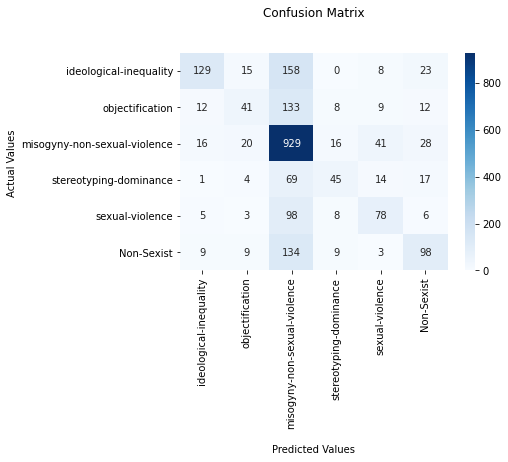

In [84]:
cf_matrix2 = confusion_matrix(Y_test2, pred_Ytask2)
ax = sns.heatmap(cf_matrix2, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['ideological-inequality','objectification','misogyny-non-sexual-violence','stereotyping-dominance','sexual-violence','Non-Sexist'])
ax.yaxis.set_ticklabels(['ideological-inequality','objectification','misogyny-non-sexual-violence','stereotyping-dominance','sexual-violence','Non-Sexist'])

## Display the visualization of the Confusion Matrix.
for item in ax.get_yticklabels():
    item.set_rotation(0)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [85]:
predsexistsongstask2=lr_modeltask2.predict(cvtask2.transform(song_df['text_fin'])) # predicting
#checking the accuracy

In [86]:
predsexistsongstask2

array(['stereotyping-dominance', 'misogyny-non-sexual-violence',
       'stereotyping-dominance', 'objectification',
       'stereotyping-dominance', 'non-sexist',
       'misogyny-non-sexual-violence', 'non-sexist', 'objectification',
       'non-sexist', 'stereotyping-dominance', 'non-sexist', 'non-sexist',
       'non-sexist', 'stereotyping-dominance', 'non-sexist',
       'misogyny-non-sexual-violence', 'stereotyping-dominance',
       'stereotyping-dominance', 'objectification'], dtype=object)

# Important featurers For Classifier

In [87]:
def important_features_per_class(vectorizer,classifier,n=80):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words in sexist documents")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in neutral documents")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat) 
 
    
# example of how to call from notebook:
important_features_per_class(cv, clf)

Important words in sexist documents
0 689.0 women
0 431.0 like
0 295.0 men
0 241.0 woman
0 219.0 look
0 179.0 want
0 159.0 fuck
0 153.0 get
0 146.0 say
0 136.0 man
0 131.0 femin
0 129.0 make
0 123.0 know
0 120.0 go
0 118.0 look like
0 117.0 call
0 115.0 think
0 111.0 one
0 107.0 bitch
0 106.0 girl
0 104.0 sex
0 98.0 feminist
0 96.0 peopl
0 92.0 cock
0 90.0 love
0 89.0 whore
0 88.0 ass
0 84.0 would
0 83.0 time
0 81.0 spank
0 79.0 need
0 79.0 amp
0 78.0 see
0 74.0 hate
0 71.0 way
0 70.0 wife
0 70.0 good
0 68.0 even
0 66.0 thing
0 65.0 let
0 63.0 use
0 63.0 take
0 63.0 shit
0 62.0 right
0 60.0 still
0 60.0 said
0 60.0 got
0 58.0 work
0 58.0 sexist
0 57.0 sexual
0 57.0 rape
0 56.0 prostitut
0 55.0 year
0 55.0 tell
0 55.0 realli
0 54.0 much
0 54.0 everi
0 54.0 day
0 53.0 ladi
0 52.0 pussi
0 51.0 talk
0 51.0 never
0 51.0 feel
0 50.0 guy
0 48.0 us
0 48.0 femal
0 47.0 porn
0 47.0 husband
0 47.0 come
0 46.0 slut
0 46.0 life
0 45.0 understand
0 45.0 trophi
0 45.0 male
0 44.0 without
0 44.0 littl

/Users/kiliandiederix/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
